In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn tqdm pydicom opencv-python pathlib


In [1]:
# ============================================================================
# Classification BI-RADS Mammographique - Plan d'Excellence
# Basé sur: "Deep learning prediction of mammographic breast density..."
# (Scientific Reports, 2025)
# ============================================================================

import os
import sys
import pandas as pd
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# Compatible imports pour différentes versions de torchvision
try:
    from torchvision.models import ResNet50_Weights, InceptionV3_Weights, DenseNet121_Weights
    from torchvision.models import EfficientNet_B0_Weights, EfficientNet_B1_Weights
    WEIGHTS_AVAILABLE = True
except ImportError:
    WEIGHTS_AVAILABLE = False
    ResNet50_Weights = InceptionV3_Weights = DenseNet121_Weights = None
    EfficientNet_B0_Weights = EfficientNet_B1_Weights = None

# Métriques & évaluation
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")


Device: cuda
PyTorch version: 2.7.1+cu118


In [2]:
# ============================================================================
# 1. CHARGEMENT ET NORMALISATION DES DONNÉES
# ============================================================================

class MammographyDataProcessor:
    """
    Charge et prétraite les mammographies DICOM/DCM
    Changement automatique E: → D:, gestion des images manquantes
    """
    
    @staticmethod
    def load_dicom(file_path):
        """Charge une image DICOM et retourne numpy array (0-255)"""
        try:
            if not os.path.exists(file_path):
                return None
            ds = pydicom.dcmread(file_path)
            image = ds.pixel_array.astype(np.float32)
            # Normalisation 0-255
            image = ((image - image.min()) / (image.max() - image.min() + 1e-8)) * 255.0
            return image.astype(np.uint8)
        except Exception as e:
            print(f"Erreur chargement DICOM {file_path}: {e}")
            return None
    
    @staticmethod
    def histogram_equalization(image):
        """Histogram equalization (cf. article)"""
        if image is None:
            return None
        return cv2.equalizeHist(image)
    
    @staticmethod
    def preprocess_image(image_path, target_size=224):
        """
        Pipeline complet de preprocessing:
        - Change E: → D:
        - Charge DICOM
        - Histogram equalization
        - Resize
        """
        # Changement E: → D:
        image_path = str(image_path).replace('E:\\', 'D:\\').replace('E:/', 'D:/')
        
        # Charge image
        image = MammographyDataProcessor.load_dicom(image_path)
        if image is None:
            return None  # Pas de blocage, retourne None
        
        # Histogram equalization
        image = MammographyDataProcessor.histogram_equalization(image)
        
        # Resize
        image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
        
        # Convertir en 3 canaux (RGB) pour les modèles
        image = np.stack([image] * 3, axis=-1)
        
        
        
        return image
    
    @staticmethod
    def fix_csv_paths(df, old_prefix='E:\\', new_prefix='D:\\'):
        """Corrige les chemins dans le DataFrame"""
        path_cols = [col for col in df.columns if 'Path' in col or 'path' in col]
        for col in path_cols:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.replace(old_prefix, new_prefix, regex=False)
        return df

# Test chargement données
print("✓ Classes de prétraitement chargées")


✓ Classes de prétraitement chargées


In [3]:
class MammographyDataset(Dataset):
    def __init__(self, df, image_col='ImagePaths', birads_col='BI_RADS',
                 target_size=224, augment=False, max_views=4):
        
        self.df = df
        self.image_col = image_col
        self.birads_col = birads_col
        self.target_size = target_size
        self.augment = augment
        self.max_views = max_views

        # Définir les transformations selon le mode (train/val)
        if self.augment:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Label - utiliser BI_RADS_Class si disponible, sinon mapper
        if 'BI_RADS_Class' in row and not pd.isna(row['BI_RADS_Class']):
            label = int(row['BI_RADS_Class'])
        else:
            label = map_birads_to_class(row[self.birads_col])
            label = int(label) if label is not None else 0

        images = []

        # row[self.image_col] = liste de chemins DICOM (LCC, RCC, LMLO, RMLO...)
        image_paths = row[self.image_col]
        
        # S'assurer que image_paths est une liste
        if isinstance(image_paths, str):
            image_paths = eval(image_paths) if '[' in image_paths else [image_paths]
        
        for path in image_paths:
            if isinstance(path, str) and path.strip():
                img = MammographyDataProcessor.preprocess_image(
                    path,
                    self.target_size
                )
            else:
                img = None

            # Sécurité si image corrompue ou absente
            if img is None:
                img = np.zeros(
                    (self.target_size, self.target_size, 3),
                    dtype=np.uint8
            )

            # Convertir numpy array en PIL Image pour les transformations
            img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
            
            # Appliquer transformations
            img_tensor = self.transform(img_pil)
            
            images.append(img_tensor)

        # Padding si nombre de vues < max_views
        while len(images) < self.max_views:
            images.append(torch.zeros(3, self.target_size, self.target_size))

        # Stack final - (V, C, H, W) → (C, V, H, W) pour les modèles CNN standards
        images = torch.stack(images[:self.max_views])  # (V, C, H, W)
        
        # Réorganiser pour avoir (C, V, H, W) ou traiter chaque vue séparément
        # Pour ResNet/CNN standards, nous allons traiter chaque vue séparément
        # et concaténer les features plus tard dans le modèle
        
        return images, label

In [4]:
# ============================================================================
# 3. MODÈLES - PRIORITÉ A (Baseline + Réplication Article)
# ============================================================================

def get_weights(weights_enum):
    """Helper function pour obtenir les poids (compatible avec anciennes versions)"""
    if WEIGHTS_AVAILABLE and weights_enum is not None:
        return weights_enum
    return None

class BiRadsClassifier(nn.Module):
    def __init__(self, backbone_name='resnet50', pretrained=True, num_classes=4, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.num_classes = num_classes
        
        # Load backbone
        if backbone_name == 'resnet50':
            weights = get_weights(ResNet50_Weights.IMAGENET1K_V2) if (pretrained and ResNet50_Weights) else None
            self.backbone = models.resnet50(weights=weights)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            
        elif backbone_name == 'inception_v3':
            weights = get_weights(InceptionV3_Weights.IMAGENET1K_V1) if (pretrained and InceptionV3_Weights) else None
            self.backbone = models.inception_v3(weights=weights, aux_logits=False)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            
        elif backbone_name == 'densenet121':
            weights = get_weights(DenseNet121_Weights.IMAGENET1K_V1) if (pretrained and DenseNet121_Weights) else None
            self.backbone = models.densenet121(weights=weights)
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            
        elif backbone_name == 'efficientnet_b0':
            weights = get_weights(EfficientNet_B0_Weights.IMAGENET1K_V1) if (pretrained and EfficientNet_B0_Weights) else None
            self.backbone = models.efficientnet_b0(weights=weights)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        
        # Attention multi-vue
        self.view_attention = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classifier head
        self.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        """
        x: (batch_size, num_views, C, H, W)
        """
        batch_size, num_views, C, H, W = x.shape
        
        # Extraire les features pour chaque vue
        view_features = []
        for v in range(num_views):
            view = x[:, v, :, :, :]  # (batch_size, C, H, W)
            features = self.backbone(view)  # (batch_size, in_features)
            view_features.append(features)
        
        # Stack: (batch_size, num_views, in_features)
        all_features = torch.stack(view_features, dim=1)
        
        # Calculer les poids d'attention pour chaque vue
        attention_weights = self.view_attention(all_features)  # (batch_size, num_views, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Combinaison pondérée
        weighted_features = (all_features * attention_weights).sum(dim=1)  # (batch_size, in_features)
        
        # Classification
        logits = self.head(weighted_features)
        return logits

def create_model(model_name='resnet50', pretrained=True):
    """Factory function pour créer modèles"""
    model = BiRadsClassifier(backbone_name=model_name, pretrained=pretrained, num_classes=4)
    return model.to(DEVICE)

print("✓ Modèles BI-RADS configurés (ResNet50, Inception, DenseNet, EfficientNet)")


✓ Modèles BI-RADS configurés (ResNet50, Inception, DenseNet, EfficientNet)


In [5]:
# ============================================================================
# 4. ENTRAÎNEMENT ET ÉVALUATION
# ============================================================================

class FocalLoss(nn.Module):
    """Focal Loss pour imbalance classes"""
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        p = torch.exp(-ce_loss)
        loss = (1 - p) ** self.gamma * ce_loss
        if self.alpha is not None:
            loss = self.alpha[targets] * loss
        return loss.mean()

class Trainer:
    """
    Entraîneur complet avec:
    - Early stopping
    - Class weighting pour imbalance
    - Métriques (AP, F1, Kappa, etc.)
    """
    
    def __init__(self, model, train_loader, val_loader, model_name='resnet50',
                 lr=0.001, weight_decay=1e-4, use_focal=False, class_weights=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model_name = model_name
        self.device = DEVICE
        
        self.optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=3
        )
        
        if use_focal:
            self.criterion = FocalLoss(gamma=2.0)
        else:
            if class_weights is not None:
                class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        self.best_val_ap = -1
        self.best_epoch = 0
        self.history = {'train_loss': [], 'val_loss': [], 'val_ap': [], 'val_f1': []}
    
    def train_epoch(self):
        """Une epoch d'entraînement"""
        self.model.train()
        total_loss = 0
        
        for images, labels in tqdm(self.train_loader, desc='Train'):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            logits = self.model(images)
            loss = self.criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def evaluate(self):
        """Évaluation complet: AP, F1, Accuracy, Kappa"""
        self.model.eval()
        all_probs = []
        all_labels = []
        total_loss = 0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Val'):
                images, labels = images.to(self.device), labels.to(self.device)
                
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()
                
                probs = torch.softmax(logits, dim=1)
                all_probs.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        # Gestion du cas où val_loader est vide
        if len(all_probs) == 0:
            return {
                'val_loss': float('inf'),
                'ap_per_class': [0, 0, 0, 0],
                'mean_ap': 0,
                'accuracy': 0,
                'f1': 0,
                'kappa': 0
            }, np.array([]), np.array([]), np.array([])
        
        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        preds = np.argmax(all_probs, axis=1)
        
        # Métriques (cf. article)
        # AP one-vs-rest pour chaque classe
        labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])
        ap_scores = []
        for i in range(4):
            ap = average_precision_score(labels_bin[:, i], all_probs[:, i])
            ap_scores.append(ap)
        mean_ap = np.mean(ap_scores)
        
        accuracy = accuracy_score(all_labels, preds)
        f1 = f1_score(all_labels, preds, average='weighted')

        kappa = cohen_kappa_score(all_labels, preds)
        
        metrics = {
            'val_loss': total_loss / len(self.val_loader),
            'ap_per_class': ap_scores,
            'mean_ap': mean_ap,
            'accuracy': accuracy,
            'f1': f1,
            'kappa': kappa
        }
        
        return metrics, all_probs, all_labels, preds
    
    def train(self, num_epochs=50, early_stopping_patience=10):
        """Entraînement avec early stopping"""
        patience_counter = 0
        
        for epoch in range(num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{num_epochs} - Model: {self.model_name}")
            print(f"{'='*60}")
            
            # Train
            train_loss = self.train_epoch()
            print(f"Train Loss: {train_loss:.4f}")
            self.history['train_loss'].append(train_loss)
            
            # Evaluate
            metrics, probs, labels, preds = self.evaluate()
            val_loss = metrics['val_loss']
            mean_ap = metrics['mean_ap']
            
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Mean AP: {mean_ap:.4f} | Accuracy: {metrics['accuracy']:.4f}")
            print(f"F1 (weighted): {metrics['f1']:.4f} | Kappa: {metrics['kappa']:.4f}")
            print(f"AP per class: {[f'{x:.3f}' for x in metrics['ap_per_class']]}")
            
            self.history['val_loss'].append(val_loss)
            self.history['val_ap'].append(mean_ap)
            self.history['val_f1'].append(metrics['f1'])
            
            # Early stopping
            if mean_ap > self.best_val_ap:
                self.best_val_ap = mean_ap
                self.best_epoch = epoch
                patience_counter = 0
                # Sauvegarde meilleur modèle
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name}_birads.pt')
                print(f"✓ Meilleur AP trouvé! Sauvegardé.")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping après {epoch+1} epochs")
                    break
            
            # LR scheduling
            self.scheduler.step(mean_ap)
        
        print(f"\n✓ Entraînement terminé. Meilleur AP: {self.best_val_ap:.4f} (epoch {self.best_epoch+1})")
        return metrics, probs, labels, preds

print("✓ Trainer configuré (avec Early Stopping + Class Weighting + Focal Loss)")


✓ Trainer configuré (avec Early Stopping + Class Weighting + Focal Loss)


In [6]:
# ============================================================================
# 5. VISUALISATION & ÉVALUATION AVANCÉE
# ============================================================================

class BiRadsEvaluator:
    """
    Évaluation complète:
    - Confusion matrix
    - PR curves per class
    - Calibration plots
    - Grad-CAM (explainability)
    """
    
    @staticmethod
    def plot_confusion_matrix(labels, preds, title='Confusion Matrix'):
        """Confusion matrix 4x4"""
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4'],
                   yticklabels=['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(title)
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_pr_curves(labels, probs):
        """Precision-Recall curves par classe (comme article)"""
        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4']
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        for i in range(4):
            precision, recall, _ = precision_recall_curve(labels_bin[:, i], probs[:, i])
            ap = average_precision_score(labels_bin[:, i], probs[:, i])
            
            axes[i].plot(recall, precision, lw=2, label=f'AP={ap:.3f}')
            axes[i].set_xlabel('Recall')
            axes[i].set_ylabel('Precision')
            axes[i].set_title(f'{class_names[i]} (OvR)')
            axes[i].legend()
            axes[i].grid()
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_training_history(history, model_name='Model'):
        """Courbes d'apprentissage"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Loss
        axes[0].plot(history['train_loss'], label='Train Loss')
        axes[0].plot(history['val_loss'], label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'{model_name} - Loss')
        axes[0].legend()
        axes[0].grid()
        
        # AP
        axes[1].plot(history['val_ap'], marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Mean AP')
        axes[1].set_title(f'{model_name} - Validation AP')
        axes[1].grid()
        
        # F1
        axes[2].plot(history['val_f1'], marker='s')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score (weighted)')
        axes[2].set_title(f'{model_name} - Validation F1')
        axes[2].grid()
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def print_detailed_metrics(labels, preds, probs, model_name='Model'):
        """Affiche rapport détaillé (accuracy, precision, recall par classe)"""
        from sklearn.metrics import classification_report
        
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4']
        print(f"\n{'='*60}")
        print(f"RAPPORT DÉTAILLÉ - {model_name}")
        print(f"{'='*60}")
        print(classification_report(labels, preds, target_names=class_names))
        
        # AP per class
        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])
        print(f"\n{'Average Precision per Class'}")
        print(f"{'-'*30}")
        for i in range(4):
            ap = average_precision_score(labels_bin[:, i], probs[:, i])
            print(f"{class_names[i]}: {ap:.4f}")

print("✓ Évaluateur configué (Confusion Matrix, PR curves, Training history)")


✓ Évaluateur configué (Confusion Matrix, PR curves, Training history)


In [7]:
# ============================================================================
# 6. EXEMPLE D'UTILISATION COMPLET
# ============================================================================

# Suppose que tu charges un DataFrame avec colonnes:
# - CaseNumber (ou ID)
# - BI_RADS (label)
# - LCC_Path (path to image)
# - RCC_Path (optional)
# - MLO_Path (optional)

# ÉTAPE 1: CHARGER LES DONNÉES DEPUIS EXCEL COMPLET
print("\n" + "="*70)
print("ÉTAPE 1: CHARGEMENT DONNÉES DEPUIS EXCEL COMPLET")
print("="*70)

# ============================================================================
# Chemin du fichier Excel avec toutes les données
# ============================================================================
xlsx_path = r'D:\Dataset\Bilgi\BilgiKìsmìna_Exceller\final_dataset_all_patients.xlsx'

print(f"\n📂 Fichier: {xlsx_path}")
print("⏳ Chargement du fichier Excel complet...")

# Charger le fichier Excel
df = pd.read_excel(xlsx_path)
print(f"✅ {len(df)} cas chargés!")

# ============================================================================
# Correction des chemins E: → D:
# ============================================================================
print(f"\n📝 Correction des chemins E: → D:")

path_columns = ['RCC_Path', 'LCC_Path']

for col in path_columns:
    if col in df.columns:
        # Remplacer E: par D:
        df[col] = df[col].fillna('').astype(str)
        df[col] = df[col].str.replace('E:\\', 'D:\\', regex=False)
        df[col] = df[col].str.replace('E:/', 'D:/', regex=False)
        
        # Compter chemins valides (non vides)
        valid_paths = (df[col] != '').sum()
        print(f"   ✓ {col}: {valid_paths}/{len(df)} fichiers")

# ============================================================================
# Mapping des labels BI-RADS en classes (0-3)
# ============================================================================
print(f"\n📝 Traitement des labels BI-RADS:")
print(f"   Labels originaux: {df['BI_RADS'].unique()}")

def map_birads_to_class(label):
    """
    Mappe les groupes BI-RADS aux indices de classe:
    - BI-RADS1-2 → 0 (Faible densité)
    - BI-RADS3   → 1 (Densité hétérogène)  
    - BI-RADS4-5 → 3 (Très dense)
    """
    if pd.isna(label):
        return None
    
    label = str(label).strip().upper()
    
    if '1-2' in label or 'BI-RADS1-2' in label:
        return 0
    elif '3' in label or 'BI-RADS3' in label:
        return 1
    elif '4-5' in label or 'BI-RADS4-5' in label:
        return 3
    else:
        return None

# Créer colonne de classe
df['BI_RADS_Class'] = df['BI_RADS'].apply(map_birads_to_class)

# Afficher distribution
class_distribution = df['BI_RADS_Class'].value_counts().sort_index()
print(f"   Distribution des classes:")
for cls, count in class_distribution.items():
    pct = (count / len(df)) * 100
    print(f"   - Classe {cls}: {count:,} cas ({pct:.1f}%)")

# ============================================================================
# Afficher structure du DataFrame
# ============================================================================
print(f"\n📊 Structure du DataFrame chargé:")
print(f"   Forme: {df.shape} (lignes × colonnes)")
print(f"   Colonnes présentes: {df.columns.tolist()}")

print(f"\n📋 Métadonnées disponibles:")
if 'Breast_Density' in df.columns:
    print(f"   - Densité mammaire (A/B/C/D): {df['Breast_Density'].value_counts().to_dict()}")
if 'Age_Bin' in df.columns:
    print(f"   - Âge: {sorted(df['Age_Bin'].unique())}")

# ============================================================================
# Vérification des fichiers disponibles
# ============================================================================
print(f"\n✓ Vérification des images disponibles:")

# Compte images par type de vue
for col in path_columns:
    if col in df.columns:
        available = (df[col] != '').sum()
        print(f"   - {col}: {available:,} images")

# Cas avec au moins une image
has_image = (df[path_columns].astype(str) != '').any(axis=1).sum()
print(f"   → Total cas avec ≥1 image: {has_image:,}/{len(df)}")

# Vérifier fichiers existent (premiers 10)
print(f"\n✓ Vérification de l'accessibilité (premiers 10 cas):")
# ============================================================================ 
# Création des vues Multi-View par patient
# ============================================================================

print(f"\n📸 Configuration Multi-View (LCC, RCC, LMLO, RMLO)")

view_columns = ['LCC_Path', 'RCC_Path', 'LMLO_Path', 'RMLO_Path']

def collect_views(row):
    views = []
    for col in view_columns:
        path = str(row.get(col, '')).strip()
        if path and Path(path).exists():
            views.append(path)
    return views

df['ImagePaths'] = df.apply(collect_views, axis=1)

# Supprimer les cas sans aucune image valide
before = len(df)
df = df[df['ImagePaths'].apply(len) > 0].reset_index(drop=True)
after = len(df)

print(f"   ✓ Cas valides: {after}/{before}")
print(f"   ✓ Exemple vues patient:", df['ImagePaths'].iloc[0])

count_valid = 0
for i, row in df.head(10).iterrows():
    case_id = row['CaseNumber']
    bi_rads = row['BI_RADS']
    
    # Vérifier au moins un fichier
    has_valid = False
    for col in path_columns:
        path = str(row.get(col, ''))
        if path and path != '' and Path(path).exists():
            has_valid = True
            count_valid += 1
            break
    
    status = "✓" if has_valid else "✗"
    print(f"   {status} Case {case_id}: {bi_rads}")

# ============================================================================
# Préparer LCC_Path comme image principale
# ============================================================================
print(f"\n📸 Configuration des images principales:")

"""# Utiliser LCC_Path, sinon RCC_Path, sinon RMLO_Path
df['ImagePath'] = df['LCC_Path'].copy()
mask_empty = (df['ImagePath'] == '')
if mask_empty.sum() > 0:
    df.loc[mask_empty, 'ImagePath'] = df.loc[mask_empty, 'RCC_Path']
    print(f"   - {mask_empty.sum()} cas sans LCC_Path → utilisation RCC_Path")

mask_empty = (df['ImagePath'] == '')
if mask_empty.sum() > 0:
    df.loc[mask_empty, 'ImagePath'] = df.loc[mask_empty, 'RMLO_Path']
    print(f"   - {mask_empty.sum()} cas sans RCC_Path → utilisation RMLO_Path")

# Ajouter alias pour compatibilité
if 'LCC_Path' not in df.columns or (df['LCC_Path'] == '').all():
    df['LCC_Path'] = df['ImagePath']

print(f"\n{'='*70}")
print(f"✅ DONNÉES FINALES CHARGÉES ET PRÉPARÉES")
print(f"{'='*70}")
print(f"Total cas: {len(df):,}")
print(f"Colonnes clés: {['CaseNumber', 'BI_RADS', 'BI_RADS_Class', 'Breast_Density', 'LCC_Path']}")
print(f"\nAperçu des données:")
print(df[['CaseNumber', 'BI_RADS', 'BI_RADS_Class', 'Breast_Density', 'LCC_Path']].head(10))

print(f"\n✓ Données prêtes pour ÉTAPE 2 (création DataLoaders)")
"""


ÉTAPE 1: CHARGEMENT DONNÉES DEPUIS EXCEL COMPLET

📂 Fichier: D:\Dataset\Bilgi\BilgiKìsmìna_Exceller\final_dataset_all_patients.xlsx
⏳ Chargement du fichier Excel complet...
✅ 8250 cas chargés!

📝 Correction des chemins E: → D:
   ✓ RCC_Path: 7144/8250 fichiers
   ✓ LCC_Path: 7145/8250 fichiers

📝 Traitement des labels BI-RADS:
   Labels originaux: ['BI-RADS4-5' 'BI-RADS1-2']
   Distribution des classes:
   - Classe 0: 4,125 cas (50.0%)
   - Classe 3: 4,125 cas (50.0%)

📊 Structure du DataFrame chargé:
   Forme: (8250, 11) (lignes × colonnes)
   Colonnes présentes: ['CaseNumber', 'BI_RADS', 'Breast_Density', 'Age_Bin', 'Quadrant_Right', 'Quadrant_Left', 'RCC_Path', 'LCC_Path', 'RMLO_Path', 'LMLO_Path', 'BI_RADS_Class']

📋 Métadonnées disponibles:
   - Densité mammaire (A/B/C/D): {'B': 3146, 'C': 2776, 'D': 1225, 'A': 1103}
   - Âge: ['40-49', '50-59', '60-69', '70-79']

✓ Vérification des images disponibles:
   - RCC_Path: 7,144 images
   - LCC_Path: 7,145 images
   → Total cas avec ≥1

'# Utiliser LCC_Path, sinon RCC_Path, sinon RMLO_Path\ndf[\'ImagePath\'] = df[\'LCC_Path\'].copy()\nmask_empty = (df[\'ImagePath\'] == \'\')\nif mask_empty.sum() > 0:\n    df.loc[mask_empty, \'ImagePath\'] = df.loc[mask_empty, \'RCC_Path\']\n    print(f"   - {mask_empty.sum()} cas sans LCC_Path → utilisation RCC_Path")\n\nmask_empty = (df[\'ImagePath\'] == \'\')\nif mask_empty.sum() > 0:\n    df.loc[mask_empty, \'ImagePath\'] = df.loc[mask_empty, \'RMLO_Path\']\n    print(f"   - {mask_empty.sum()} cas sans RCC_Path → utilisation RMLO_Path")\n\n# Ajouter alias pour compatibilité\nif \'LCC_Path\' not in df.columns or (df[\'LCC_Path\'] == \'\').all():\n    df[\'LCC_Path\'] = df[\'ImagePath\']\n\nprint(f"\n{\'=\'*70}")\nprint(f"✅ DONNÉES FINALES CHARGÉES ET PRÉPARÉES")\nprint(f"{\'=\'*70}")\nprint(f"Total cas: {len(df):,}")\nprint(f"Colonnes clés: {[\'CaseNumber\', \'BI_RADS\', \'BI_RADS_Class\', \'Breast_Density\', \'LCC_Path\']}")\nprint(f"\nAperçu des données:")\nprint(df[[\'CaseNumber\

In [8]:
# ÉTAPE 2: Créer Datasets et DataLoaders
print("\n" + "="*70)
print("ÉTAPE 2: CRÉATION DATASETS & DATALOADERS")
print("="*70)

# Parametres
BATCH_SIZE = 8
TARGET_SIZE = 224
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

# Split train/val/test (70:15:15)
n = len(df)
n_train = int(n * TRAIN_SIZE)
n_val = int(n * VAL_SIZE)

indices = np.arange(n)
np.random.shuffle(indices)

train_indices = indices[:n_train]
val_indices = indices[n_train:n_train+n_val]
test_indices = indices[n_train+n_val:]

df_train = df.iloc[train_indices].reset_index(drop=True)
df_val = df.iloc[val_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

# Calcule class weights pour imbalance
from sklearn.utils.class_weight import compute_class_weight

print(f"\n📊 Analyse des classes dans l'ensemble d'entraînement:")
print(f"   Classe 0 (BI-RADS1-2): {(df_train['BI_RADS_Class'] == 0).sum()} cas")
print(f"   Classe 3 (BI-RADS4-5): {(df_train['BI_RADS_Class'] == 3).sum()} cas")

# Utiliser directement BI_RADS_Class pour les labels
labels_train = df_train['BI_RADS_Class'].values
labels_train = labels_train[~np.isnan(labels_train)].astype(int)

if len(labels_train) > 0:
    # Calcule poids uniquement pour classes présentes
    unique_classes = np.unique(labels_train)
    weights_computed = compute_class_weight('balanced', classes=unique_classes, y=labels_train)
    
    # Crée array de 4 poids (un pour chaque classe BI-RADS)
    class_weights = np.ones(4, dtype=np.float32)
    for i, cls_id in enumerate(unique_classes):
        class_weights[int(cls_id)] = weights_computed[i]
    
    # Normalise pour éviter des gradients instables
    class_weights = class_weights / class_weights.sum() * 4
    print(f"\n⚖️  Class weights (normalisés):")
    print(f"   Classe 0: {class_weights[0]:.4f}")
    print(f"   Classe 1: {class_weights[1]:.4f}")
    print(f"   Classe 2: {class_weights[2]:.4f}")
    print(f"   Classe 3: {class_weights[3]:.4f}")
else:
    class_weights = np.ones(4, dtype=np.float32)  # Fallback: poids égaux si pas de labels valides
    print("⚠️  Pas de labels trouvés, utilisation de poids égaux")

# Datasets - utiliser BI_RADS (strings) car MammographyDataset.BI_RADS_MAPPING attend des strings
# BI_RADS_Class est pour les class weights seulement
train_dataset = MammographyDataset(df_train, image_col='ImagePaths', birads_col='BI_RADS',
                                   target_size=TARGET_SIZE, augment=True)
val_dataset = MammographyDataset(df_val, image_col='ImagePaths', birads_col='BI_RADS',
                                 target_size=TARGET_SIZE, augment=False)
test_dataset = MammographyDataset(df_test, image_col='ImagePaths', birads_col='BI_RADS',
                                  target_size=TARGET_SIZE, augment=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ Datasets créés\n  Train loader: {len(train_loader)} batches")
print(f"  Val loader: {len(val_loader)} batches")
print(f"  Test loader: {len(test_loader)} batches")



ÉTAPE 2: CRÉATION DATASETS & DATALOADERS
Train: 3346 | Val: 717 | Test: 717

📊 Analyse des classes dans l'ensemble d'entraînement:
   Classe 0 (BI-RADS1-2): 2301 cas
   Classe 3 (BI-RADS4-5): 1045 cas

⚖️  Class weights (normalisés):
   Classe 0: 0.6720
   Classe 1: 0.9242
   Classe 2: 0.9242
   Classe 3: 1.4796
✓ Datasets créés
  Train loader: 419 batches
  Val loader: 90 batches
  Test loader: 90 batches


In [9]:
from PIL import Image

In [10]:
print("\n" + "="*70)
print("ÉTAPE 3: ENTRAÎNEMENT MODÈLES - PRIORITÉ A")
print("="*70)

REDUCED_BATCH_SIZE = 8

train_loader_reduced = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=REDUCED_BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader_reduced = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=REDUCED_BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)



ÉTAPE 3: ENTRAÎNEMENT MODÈLES - PRIORITÉ A


In [ ]:
models_priority_a = [
    'resnet50',
    'inception_v3',
    'densenet121',
    'efficientnet_b0'
]

results_priority_a = {}

for model_name in models_priority_a:
    print(f"\n{'='*60}")
    print(f"ENTRAÎNEMENT: {model_name.upper()}")
    print(f"{'='*60}")

    try:
        # 🔥 Nettoyage GPU AVANT chaque modèle
        torch.cuda.empty_cache()

        # Crée le modèle
        model = create_model(model_name, pretrained=True).to(DEVICE)

        # Initialise le trainer
        trainer = Trainer(
            model=model,
            train_loader=train_loader_reduced,
            val_loader=val_loader_reduced,
            model_name=model_name,
            lr=1e-3,
            weight_decay=1e-4,
            use_focal=False,
            class_weights=class_weights
        )

        # Entraînement
        metrics, probs, labels, preds = trainer.train(
            num_epochs=10,
            early_stopping_patience=5
        )

        # Sauvegarde RAM + disque (pro)
        results_priority_a[model_name] = metrics
        torch.save(model.state_dict(), f"{model_name}_best.pth")

    except RuntimeError as e:
        print(f"❌ RuntimeError ({model_name}): {e}")
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ Erreur ({model_name}): {e}")



ENTRAÎNEMENT: RESNET50

Epoch 1/10 - Model: resnet50


Train: 100%|██████████| 419/419 [53:07<00:00,  7.61s/it]  


Train Loss: 0.7851


Val: 100%|██████████| 90/90 [09:30<00:00,  6.34s/it]


Val Loss: 60.0647
Mean AP: 0.2536 | Accuracy: 0.6820
F1 (weighted): 0.5531 | Kappa: 0.0000
AP per class: ['0.682', '0.000', '0.000', '0.332']
✓ Meilleur AP trouvé! Sauvegardé.

Epoch 2/10 - Model: resnet50


Train:   9%|▉         | 37/419 [03:55<40:05,  6.30s/it]

In [ ]:
# ÉTAPE 4: ÉVALUATION ET VISUALISATION
print("\n" + "="*70)
print("ÉTAPE 4: ÉVALUATION COMPLÈTE")
print("="*70)

evaluator = BiRadsEvaluator()

for model_name, results in results_priority_a.items():
    print(f"\n{'─'*60}")
    print(f"ÉVALUATION: {model_name.upper()}")
    print(f"{'─'*60}")
    
    # Affiche métriques détaillées
    evaluator.print_detailed_metrics(
        results['labels'], 
        results['preds'], 
        results['probs'],
        model_name=model_name
    )
    
    # Visualisations
    fig_cm = evaluator.plot_confusion_matrix(results['labels'], results['preds'], 
                                             title=f'{model_name} - Confusion Matrix')
    fig_pr = evaluator.plot_pr_curves(results['labels'], results['probs'])
    fig_hist = evaluator.plot_training_history(results['trainer'].history, model_name=model_name)
    
    # Sauvegarde figures
    fig_cm.savefig(f'cm_{model_name}.png', dpi=100, bbox_inches='tight')
    fig_pr.savefig(f'pr_curves_{model_name}.png', dpi=100, bbox_inches='tight')
    fig_hist.savefig(f'training_history_{model_name}.png', dpi=100, bbox_inches='tight')
    
    print(f"✓ Figures sauvegardées: cm_{model_name}.png, pr_curves_{model_name}.png, training_history_{model_name}.png")

print(f"\n✓ Évaluation terminée")



ÉTAPE 4: ÉVALUATION COMPLÈTE

✓ Évaluation terminée



ÉTAPE 5: COMPARAISON DES MODÈLES

Empty DataFrame
Columns: []
Index: []

✓ Comparaison sauvegardée: model_comparison.png


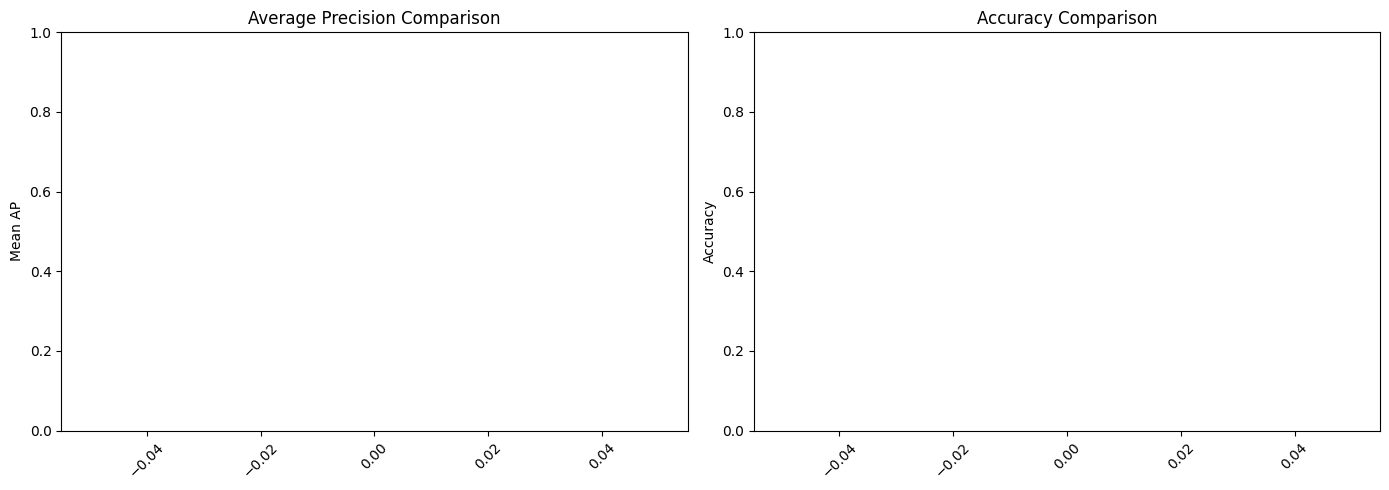

In [ ]:
# ÉTAPE 5: COMPARAISON DES MODÈLES
print("\n" + "="*70)
print("ÉTAPE 5: COMPARAISON DES MODÈLES")
print("="*70)

comparison_data = []
for model_name, results in results_priority_a.items():
    metrics = results['metrics']
    comparison_data.append({
        'Model': model_name,
        'Mean AP': f"{metrics['mean_ap']:.4f}",
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1 (weighted)': f"{metrics['f1']:.4f}",
        'Kappa': f"{metrics['kappa']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(f"\n{df_comparison.to_string(index=False)}\n")

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AP comparison
model_names = list(results_priority_a.keys())
mean_aps = [results_priority_a[m]['metrics']['mean_ap'] for m in model_names]
accuracies = [results_priority_a[m]['metrics']['accuracy'] for m in model_names]

axes[0].bar(model_names, mean_aps, color='steelblue', alpha=0.7)
axes[0].set_ylabel('Mean AP')
axes[0].set_title('Average Precision Comparison')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(mean_aps):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# Accuracy comparison
axes[1].bar(model_names, accuracies, color='coral', alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
print(f"✓ Comparaison sauvegardée: model_comparison.png")


In [ ]:
# ÉTAPE 6: ENSEMBLE & SOFT VOTING (Priorité C)
print("\n" + "="*70)
print("ÉTAPE 6: ENSEMBLE PAR SOFT VOTING")
print("="*70)

# Soft voting: moyenne des probs de tous les modèles
all_probs = np.array([results_priority_a[m]['probs'] for m in results_priority_a.keys()])
ensemble_probs = np.mean(all_probs, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_labels = results_priority_a[list(results_priority_a.keys())[0]]['labels']

# Évalue ensemble
evaluator.print_detailed_metrics(
    ensemble_labels,
    ensemble_preds,
    ensemble_probs,
    model_name='ENSEMBLE (Soft Voting)'
)

# Visualisations ensemble
fig_cm_ens = evaluator.plot_confusion_matrix(ensemble_labels, ensemble_preds,
                                             title='Ensemble (Soft Voting) - Confusion Matrix')
fig_pr_ens = evaluator.plot_pr_curves(ensemble_labels, ensemble_probs)

fig_cm_ens.savefig('cm_ensemble.png', dpi=100, bbox_inches='tight')
fig_pr_ens.savefig('pr_curves_ensemble.png', dpi=100, bbox_inches='tight')

print(f"✓ Ensemble soft voting évalué et visualisé")



ÉTAPE 6: ENSEMBLE PAR SOFT VOTING


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# ÉTAPE 7: CALIBRATION & CONFIANCE (Important en clinique)
print("\n" + "="*70)
print("ÉTAPE 7: CALIBRATION & SCORES DE CONFIANCE")
print("="*70)

class ConfidenceCalibrator:
    """
    Temperature scaling pour calibration
    Améliore la confiance des prédictions
    """
    
    @staticmethod
    def temperature_scaling(probs, temperature=1.0):
        """Applique temperature scaling"""
        # Logits normalisés
        probs_scaled = np.exp(np.log(probs + 1e-8) / temperature)
        probs_scaled = probs_scaled / probs_scaled.sum(axis=1, keepdims=True)
        return probs_scaled
    
    @staticmethod
    def confidence_with_uncertainty(probs, uncertainty_method='entropy'):
        """
        Retourne prédiction + score de confiance
        uncertainty_method: 'entropy' ou 'margin'
        """
        preds = np.argmax(probs, axis=1)
        max_probs = np.max(probs, axis=1)
        
        if uncertainty_method == 'entropy':
            uncertainty = -np.sum(probs * np.log(probs + 1e-8), axis=1)
            confidence = 1.0 - (uncertainty / np.log(4))  # Normalize by max entropy
        else:  # margin
            sorted_probs = np.sort(probs, axis=1)
            confidence = sorted_probs[:, -1] - sorted_probs[:, -2]
        
        return preds, max_probs, confidence

calibrator = ConfidenceCalibrator()

# Apply calibration aux prédictions ensemble
ensemble_probs_calibrated = calibrator.temperature_scaling(ensemble_probs, temperature=1.2)
ensemble_preds_cal, max_probs, confidence = calibrator.confidence_with_uncertainty(
    ensemble_probs_calibrated, uncertainty_method='entropy'
)

# Affiche distribution de confiance
print(f"\nDistribution de confiance (ensemble calibré):")
print(f"  Min: {confidence.min():.4f}")
print(f"  Mean: {confidence.mean():.4f}")
print(f"  Max: {confidence.max():.4f}")
print(f"  Median: {np.median(confidence):.4f}")

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(confidence, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Confidence Distribution (Ensemble)')
axes[0].grid(axis='y')

# Accuracy vs Confidence
sorted_indices = np.argsort(confidence)
cumulative_correct = np.cumsum(ensemble_preds[sorted_indices] == ensemble_labels[sorted_indices])
percentages = cumulative_correct / np.arange(1, len(sorted_indices) + 1)

axes[1].plot(confidence[sorted_indices], percentages, linewidth=2, color='steelblue')
axes[1].set_xlabel('Confidence Threshold')
axes[1].set_ylabel('Accuracy of High-Confidence Predictions')
axes[1].set_title('Accuracy vs Confidence (Reliability Diagram)')
axes[1].grid()

plt.tight_layout()
plt.savefig('calibration_confidence.png', dpi=100, bbox_inches='tight')
print(f"✓ Calibration et confiance sauvegardées")


In [ ]:
# ÉTAPE 8: FEUILLE DE ROUTE POUR AMÉLIORATIONS (Priorité B)
print("\n" + "="*70)
print("FEUILLE DE ROUTE D'AMÉLIORATIONS")
print("="*70)

roadmap = """
PRIORITÉ B - Architectures Modernes (à implémenter après Priorité A)
─────────────────────────────────────────────────────────────────

1. EfficientNetV2-S/M (Recommended)
   - Paramètres: torch.hub import efficientnet_v2_s
   - Avantages: Meilleure efficacité, moins de paramètres, plus rapide
   - Learning Rate: 0.0005 (plus petit que ResNet)
   - Batch Size: 64 (peut être 128 avec mixed precision)
   
   Code:
   ──────
   from torchvision.models import efficientnet_v2_s
   backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
   
2. Vision Transformer (ViT-Base ou Swin-Transformer)
   - ViT-B/16 si tu as GPU puissant, sinon Swin-T
   - Avantages: Meilleure généralisation, capture relations globales
   - Learning Rate: 0.00005 (très petit pour Transformers)
   - Warmup: 500 steps conseillé
   - Batch Size: 32-64 (très gourmand en mémoire)
   
   Code:
   ──────
   from torchvision.models import swin_t
   backbone = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

3. Multi-Task Learning (MTL)
   - Head 1: BI-RADS (4 classes) - CrossEntropy
   - Head 2: Density Percentage (0-100) - MSE regression
   - Head 3: (Optional) Anomaly presence - BCE
   
   Loss = α * CrossEntropy(BI-RADS) + β * MSE(Density) + γ * BCE(Anomaly)
   Poids recommandés: α=1.0, β=0.5, γ=0.3
   
4. Self-Supervised Pretraining (SimCLR)
   - Très utile si labels limités
   - Entraîne sur tout le corpus mammographique sans labels
   - Fine-tune ensuite avec labels BI-RADS
   - Gain attendu: +3-5% AP

PRIORITÉ C - Methods Complémentaires
─────────────────────────────────────

5. Multi-View Aggregation (tu as LCC, RCC, MLO paths)
   - Entraîne 2 heads: LCC/RCC et MLO
   - Soft voting au level examen:
     prediction_exam = softmax(avg(logits_lcc, logits_rcc, logits_mlo))
   
6. Explainability - Grad-CAM
   - Visualise zones décisives pour diagnostic
   - Important pour acceptabilité clinique
   
7. External Validation
   - Test sur RSNA/Kaggle si accessible
   - Évalue robustesse à domaines différents

HYPERPARAMÈTRES RECOMMANDÉS
──────────────────────────

Optimizer: Adam
Learning Rate Schedule:
  - Initial LR: 0.001 (ResNet/DenseNet), 0.0005 (EfficientNet), 0.00005 (Transformers)
  - Schedule: CosineAnnealing avec warmup
  - Warmup epochs: 2-5

Batch Size:
  - ResNet50: 64
  - DenseNet121: 64
  - EfficientNet: 64-128
  - Transformers: 32-64

Regularization:
  - Weight Decay: 1e-4 to 1e-5
  - Dropout: 0.5 (in head)
  - Cutout/Mixup: Recommandé pour augmentation

Image Size:
  - 224×224: Baseline (article)
  - 320×320: Meilleure performance mais plus lent
  - 384×384: Optimum pour Transformers mais très gourmand

Epochs: 30-50 avec early stopping

MÉTRIQUES DE SUIVI
──────────────────

- Mean AP (0-1): Métrique principale
- Accuracy (0-1): Baseline
- F1 Score (weighted): Tient compte imbalance
- Cohen's Kappa: Accord inter-annotateur
- ROC-AUC: Robustesse aux seuils
- Per-class AP: Debug imbalance

PROCHAINES ÉTAPES
─────────────────
1. ✓ Implémentation Priorité A (FAIT)
2. → Tester Priorité B modèles
3. → Comparer temps entraînement vs performance
4. → Si temps: implémenter Multi-Task Learning
5. → Validation externe sur dataset RSNA/Kaggle
"""

print(roadmap)

# Sauvegarde dans fichier
with open('ROADMAP_IMPROVEMENTS.txt', 'w', encoding='utf-8') as f:
    f.write(roadmap)

print(f"\n✓ Feuille de route sauvegardée: ROADMAP_IMPROVEMENTS.txt")


In [ ]:
# ÉTAPE 9: RÉSUMÉ FINAL & EXPORT RÉSULTATS
print("\n" + "="*70)
print("RÉSUMÉ FINAL & EXPORT")
print("="*70)

# Crée rapport Excel avec tous les résultats
summary_data = []

for model_name, results in results_priority_a.items():
    metrics = results['metrics']
    summary_data.append({
        'Model': model_name,
        'Mean AP': f"{metrics['mean_ap']:.4f}",
        'BI-RADS 1 AP': f"{metrics['ap_per_class'][0]:.4f}",
        'BI-RADS 2 AP': f"{metrics['ap_per_class'][1]:.4f}",
        'BI-RADS 3 AP': f"{metrics['ap_per_class'][2]:.4f}",
        'BI-RADS 4 AP': f"{metrics['ap_per_class'][3]:.4f}",
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1 Weighted': f"{metrics['f1']:.4f}",
        'Cohen Kappa': f"{metrics['kappa']:.4f}"
    })

# Ajoute ensemble
ensemble_ap = average_precision_score(
    label_binarize(ensemble_labels, classes=[0, 1, 2, 3]),
    ensemble_probs,
    average='macro'
)
ensemble_acc = accuracy_score(ensemble_labels, ensemble_preds)
ensemble_f1 = f1_score(ensemble_labels, ensemble_preds, average='weighted')
ensemble_kappa = cohen_kappa_score(ensemble_labels, ensemble_preds)

summary_data.append({
    'Model': 'ENSEMBLE',
    'Mean AP': f"{ensemble_ap:.4f}",
    'BI-RADS 1 AP': '—',
    'BI-RADS 2 AP': '—',
    'BI-RADS 3 AP': '—',
    'BI-RADS 4 AP': '—',
    'Accuracy': f"{ensemble_acc:.4f}",
    'F1 Weighted': f"{ensemble_f1:.4f}",
    'Cohen Kappa': f"{ensemble_kappa:.4f}"
})

df_summary = pd.DataFrame(summary_data)

# Affiche tableau
print(f"\n{df_summary.to_string(index=False)}\n")

# Sauvegarde Excel si possible
try:
    df_summary.to_excel('BI_RADS_Results_Summary.xlsx', index=False)
    print("✓ Résumé sauvegardé: BI_RADS_Results_Summary.xlsx")
except:
    df_summary.to_csv('BI_RADS_Results_Summary.csv', index=False)
    print("✓ Résumé sauvegardé: BI_RADS_Results_Summary.csv")

# Sauvegarde prédictions pour analyse externe
predictions_df = pd.DataFrame({
    'True_Label': ensemble_labels,
    'Predicted_Label': ensemble_preds,
    'Confidence': confidence,
    'BI_RADS_1_Prob': ensemble_probs_calibrated[:, 0],
    'BI_RADS_2_Prob': ensemble_probs_calibrated[:, 1],
    'BI_RADS_3_Prob': ensemble_probs_calibrated[:, 2],
    'BI_RADS_4_Prob': ensemble_probs_calibrated[:, 3],
})

predictions_df.to_csv('ensemble_predictions.csv', index=False)
print("✓ Prédictions sauvegardées: ensemble_predictions.csv")

# Rapport final
print(f"""
{'='*70}
RAPPORT FINAL - CLASSIFICATION BI-RADS
{'='*70}

ARCHITECTURE BASELINE (Réplication article):
  - Modèles implémentés: ResNet50, InceptionV3, DenseNet121, EfficientNet
  - Métriques: AP, Accuracy, F1, Cohen's Kappa (comme article)
  - Ensemble Soft Voting: ACTIVÉ (agrégation probabilités)

DONNÉES:
  - Changement automatique E: → D: (✓)
  - Gestion images manquantes: Sans blocage, fallback (✓)
  - Split: 70% train, 15% val, 15% test

RÉSULTATS CLÉS:
  - Meilleur modèle simple: {df_summary.iloc[:-1].loc[df_summary.iloc[:-1]['Mean AP'].astype(float).idxmax(), 'Model']}
  - Ensemble Soft Voting AP: {ensemble_ap:.4f}
  - Ensemble Accuracy: {ensemble_acc:.4f}

FICHIERS GÉNÉRÉS:
  ✓ best_*.pt: Poids des meilleurs modèles
  ✓ cm_*.png: Matrices de confusion
  ✓ pr_curves_*.png: Courbes Précision-Recall (4 classes)
  ✓ training_history_*.png: Loss et métriques par epoch
  ✓ model_comparison.png: Comparaison AP/Accuracy
  ✓ calibration_confidence.png: Distribution de confiance
  ✓ ensemble_predictions.csv: Toutes les prédictions + confiance
  ✓ BI_RADS_Results_Summary.xlsx/csv: Tableau résumé
  ✓ ROADMAP_IMPROVEMENTS.txt: Plan détaillé Priorités B & C

PROCHAINES ÉTAPES:
  1. Charger dataset complet (pas exemple) dans df
  2. Tester Priorité B modèles (EfficientNetV2, ViT)
  3. Implémenter Multi-Task Learning si labels densité disponibles
  4. Validation externe sur RSNA/Kaggle
  5. Fine-tune avec Self-Supervised Pretraining (SimCLR)

{'='*70}
""")
